In [ ]:
%pip install pandas numpy matplotlib seaborn tqdm gensim pyldavis pymupdf

In [2]:
import os
import glob
import re
import collections
import itertools

import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from wordcloud import WordCloud

c:\Users\pozoy\Desktop\smd\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
tqdm.pandas()

# 1. Чтение PDF и извлечение текста

In [ ]:
pdf_dir = '../data'

pdf_files = glob.glob(os.path.join(pdf_dir, '**/*.pdf'), recursive=True)
print(f'Найдено PDF файлов: {len(pdf_files)}')

def extract_text(path):
    try:
        doc = fitz.open(path)
        return '\n'.join(page.get_text('text') for page in doc)
    except Exception as e:
        print(f'Ошибка чтения {path}: {e}')
        return ''
def count_images_in_pdf(path):
    try:
        doc = fitz.open(path)
        total_images = 0
        for page in doc:
            total_images += len(page.get_images(full=True))
        return total_images
    except Exception as e:
        print(f'Ошибка подсчёта изображений в {path}: {e}')
        return None

texts = [extract_text(f) for f in tqdm(pdf_files, desc='Извлекаем текст из PDF')]
images = [count_images_in_pdf(f) for f in tqdm(pdf_files, desc='Считаем изображения в PDF')]
df = pd.DataFrame({'file': pdf_files, 'text': texts, 'n_images': images})
df['char_len'] = df['text'].str.len()
df['word_len'] = df['text'].str.split().str.len()
print(df[['file', 'char_len', 'word_len', 'n_images']].head())

Найдено PDF файлов: 10


Считаем изображения в PDF: 100%|██████████| 10/10 [00:00<00:00, 381.33it/s]


KeyError: "['n_images'] not in index"

# 2. Очистка и предварительная обработка текста

In [25]:
stop_en = set([
    'and', 'the', 'for', 'with', 'that', 'this', 'from', 'are', 'was', 'not',
    'but', 'all', 'table', 'figure', 'fig', 'mm', 'wt', 'pct'
])
stop_ru = set([
    'и', 'в', 'во', 'на', 'с', 'к', 'за', 'от', 'по', 'как', 'но', 'то', 'же',
    'для', 'рис', 'табл', 'мм', 'г', 'мкм'
])
other_noise = {'угс', 'jni', 'ppm'}

stopwords = stop_en | stop_ru | other_noise

def tokenize(text):
    # Нижний регистр, слова длиной 3+ буквы на латинице или кириллице
    tokens = re.findall(r'[a-zа-яё\-]{3,}', text.lower())
    return [t for t in tokens if t not in stopwords]

df['tokens'] = df['text'].progress_apply(tokenize)
print(df[['file', 'tokens']].head())
all_tokens = list(itertools.chain.from_iterable(df['tokens']))
tok_freq = collections.Counter(all_tokens)
print(f"Всего уникальных токенов: {len(tok_freq)}")

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 759.10it/s]

                                                file  \
0  ../data\Development of a model for copper conv...   
1  ../data\Dynamic modeling of copper flash smelt...   
2  ../data\Evaluating options to increase product...   
3  ../data\Mathematical model of whole-process ca...   
4  ../data\Metamodeling and Optimization of a Bli...   

                                              tokens  
0  [development, model, copper, converting, lenna...  
1  [dynamic, modeling, copper, ash, smelting, pro...  
2  [technical, article, evaluating, options, incr...  
3  [regular, article, mathematical, model, whole-...  
4  [metamodeling, optimization, blister, copper, ...  
Всего уникальных токенов: 5169


# 3. Частотный анализ

Топ-20 слов по частотам:
copper: 701
model: 520
process: 508
slag: 423
matte: 355
smelting: 244
optimization: 197
data: 196
can: 195
gas: 191
were: 169
production: 163
which: 159
modeling: 153
used: 145
blister: 134
converter: 129
parameters: 129
metallurgical: 126
control: 126


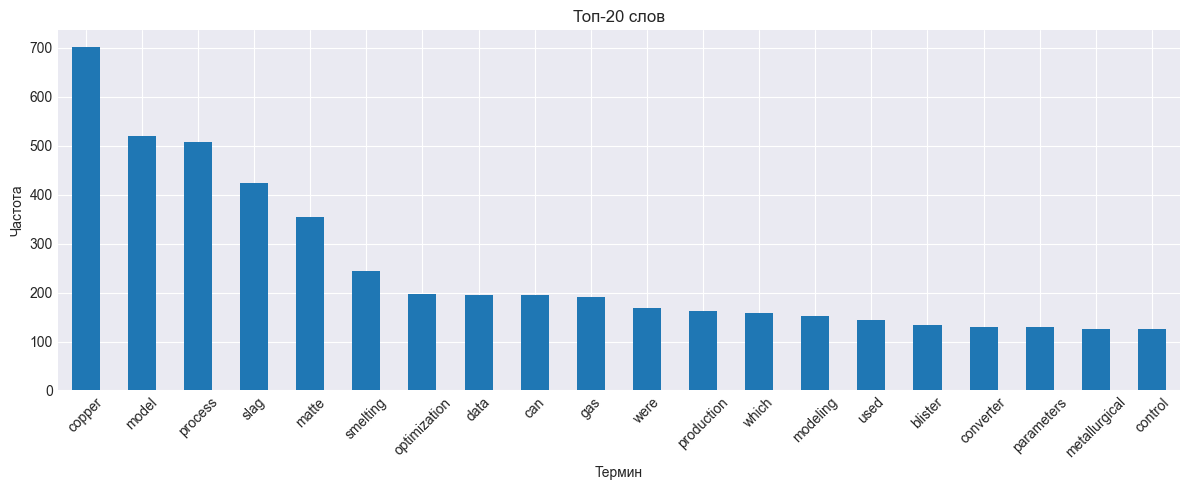

In [26]:
top20 = tok_freq.most_common(20)
print('Топ-20 слов по частотам:')
for word, count in top20:
    print(f'{word}: {count}')

top20_df = pd.DataFrame(top20, columns=['token', 'freq'])
# Удаляем строки с некорректными частотами
top20_df['freq'] = pd.to_numeric(top20_df['freq'], errors='coerce')
top20_df = top20_df.dropna(subset=['freq'])

if top20_df.empty:
    print('Нет данных для построения топ-20 токенов (частотный словарь пуст или данные некорректны).')
else:
    top20_df.plot.bar(
        x='token', y='freq', figsize=(12, 5), title='Топ-20 слов',
        legend=False
    )
    plt.xlabel('Термин')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Облако слов

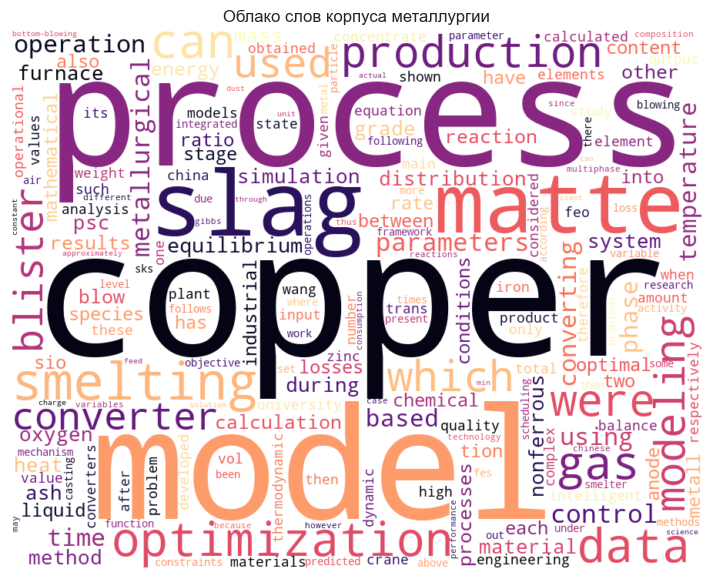

In [27]:
if tok_freq:
    wc = WordCloud(
        width=900, height=700,
        background_color='white',
        colormap='magma'
    ).generate_from_frequencies(tok_freq)

    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Облако слов корпуса металлургии')
    plt.show()
else:
    print("Облако слов не построено: словарь частот пуст.")

# 5. Распределение длины файлов

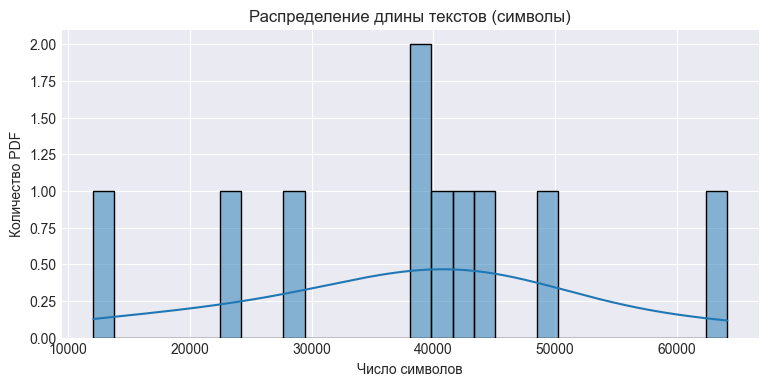

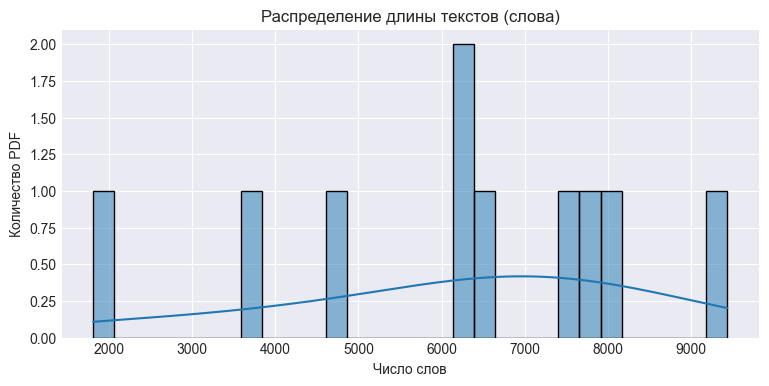

In [28]:
if not df.empty:
    plt.figure(figsize=(9, 4))
    sns.histplot(df['char_len'], bins=30, kde=True)
    plt.title('Распределение длины текстов (символы)')
    plt.xlabel('Число символов')
    plt.ylabel('Количество PDF')
    plt.show()

    plt.figure(figsize=(9, 4))
    sns.histplot(df['word_len'], bins=30, kde=True)
    plt.title('Распределение длины текстов (слова)')
    plt.xlabel('Число слов')
    plt.ylabel('Количество PDF')
    plt.show()
else:
    print("Нет данных о длине файлов — DataFrame пуст.")

# 6. Доменные термины

In [ ]:
domain_terms = [
    'copper', 'slag', 'alloy', 'smelting', 'molten', 'metal', 'casting', 'flux',
    'converter', 'ore', 'steel', 'temperature', 'oxidation', 'impurity', 'electrolysis'
]

domain_counts = {term: tok_freq.get(term, 0) for term in domain_terms}
print('Частоты доменных терминов в корпусе:')
for term, count in domain_counts.items():
    print(f'{term}: {count}') 

Частоты доменных терминов в корпусе:
copper: 701
slag: 423
alloy: 1
smelting: 244
molten: 20
metal: 41
casting: 39
flux: 8
converter: 129
ore: 15
steel: 4
temperature: 108
oxidation: 25
impurity: 11
electrolysis: 6


# 7. Сохранение результата

In [ ]:
df.to_csv('pdf_metallurgy_corpus_simple.csv', index=False)
print('Результаты анализа сохранены в: pdf_metallurgy_corpus_simple.csv') 

Результаты анализа сохранены в: pdf_metallurgy_corpus_simple.csv
